### ScienceSage RAG LLM Evaluation Metrics

![Retrieval Evaluation Metrics](../images/retrieval_evaluation_metrics.png)

*Figure: Visual summary of retrieval evaluation metrics used in ScienceSage. This diagram illustrates how each metric assesses different aspects of retrieval quality, such as accuracy, ranking, and contextual sufficiency.*



 Metric                          | Description                                                         | Formula                                                                    | Range   | Goal                                   |
|--------------------------------|---------------------------------------------------------------------|----------------------------------------------------------------------------|---------|----------------------------------------|
| Precision@K                    | Fraction of top-K retrieved chunks that are relevant.               | Precision@K = (# relevant in top K) / K                                    |  0 – 1  | Higher = more accurate retrievals      |
| Recall@K                       | Fraction of relevant chunks that appear in top-K results.           | Recall@K = (# relevant in top K) / (Total # relevant)                      |  0 – 1  | Higher = more comprehensive retrievals |
| Reciprocal Rank (MRR)          | Inverse of the rank of the first relevant chunk.                    | MRR = 1 / (rank of first relevant result)                                  |  0 – 1  | Higher = relevant results appear earlier|
| nDCG@K                         | Normalized Discounted Cumulative Gain — ranks relevance by position.| nDCG@K = DCG@K / IDCG@K, where DCG = Σ(rel_i / log2(i+2))                  |  0 – 1  | Higher = better ranking order          |
| Contextual Recall / Sufficiency| Recall-based measure for contextual completeness.                   | Same as Recall@K                                                           |  0 – 1  | Higher = covers more ground truth      |
| Semantic Similarity (MiniLM)   | Mean cosine similarity between retrieved and relevant embeddings.   | Mean cosine similarity between retrieved and relevant chunk embeddings     |  0 – 1  | Higher = more semantically aligned     |
| Fuzzy Match Recall             | Recall using fuzzy string matching for minor text differences.      | (# fuzzy matches in top K) / (Total # relevant)                            |  0 – 1  | Higher = robust to text variations     |


In [1]:
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("../sciencesage")
from sciencesage.config import GROUND_TRUTH_FILE, EVAL_RESULTS_FILE, TOP_K, METRICS_SUMMARY_FILE
from sciencesage.metrics import (
    precision_at_k,
    recall_at_k,
    reciprocal_rank,
    ndcg_at_k,
    contextual_recall_and_sufficiency,
)

2025-10-06 01:56:50.709 | INFO     | sciencesage.config:<module>:168 - Configuration loaded.


In [2]:
summary = pd.read_csv(f"../{METRICS_SUMMARY_FILE}")
summary

,metric,value
0,retrieval_precision_at_k_mean,0.087984
1,retrieval_precision_at_k_stdev,0.032577
2,retrieval_precision_at_k_min,0.000000
3,retrieval_precision_at_k_max,0.100000
4,retrieval_recall_at_k_mean,0.879845
5,retrieval_recall_at_k_stdev,0.325775
6,retrieval_recall_at_k_min,0.000000
7,retrieval_recall_at_k_max,1.000000
8,retrieval_reciprocal_rank_mean,0.691090
9,retrieval_reciprocal_rank_stdev,0.389635


In [3]:
summary['type'] = summary['metric'].str.extract(r'^(retrieval|llm)')
summary['base_metric'] = summary['metric'].str.replace(r'^(retrieval_|llm_)', '', regex=True)
summary['stat'] = summary['base_metric'].str.extract(r'_(mean|stdev|min|max)$')
summary['metric_name'] = summary['base_metric'].str.replace(r'_(mean|stdev|min|max)$', '', regex=True)

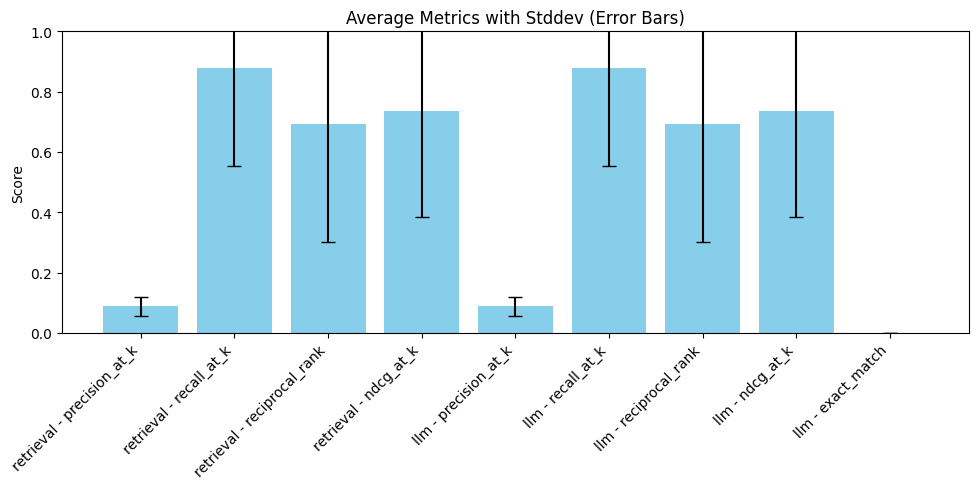

In [4]:
mean_metrics = summary[summary['stat'] == 'mean'].copy()
mean_metrics['label'] = mean_metrics['type'] + ' - ' + mean_metrics['metric_name']
mean_metrics = mean_metrics.set_index('label')

std_metrics = summary[summary['stat'] == 'stdev'].copy()
std_metrics['label'] = std_metrics['type'] + ' - ' + std_metrics['metric_name']
std_metrics = std_metrics.set_index('label')

labels = mean_metrics.index
means = mean_metrics['value']
stds = std_metrics.reindex(labels)['value']

plt.figure(figsize=(10, 5))
plt.bar(labels, means, yerr=stds, capsize=5, color='skyblue')
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Average Metrics with Stddev (Error Bars)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

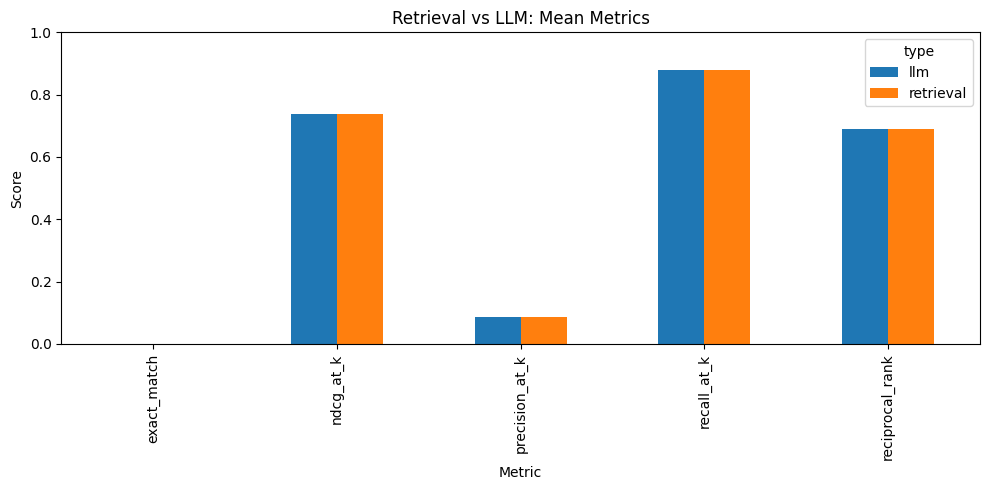

In [5]:
pivot = mean_metrics.reset_index()
pivot = pivot[['type', 'metric_name', 'value']]
pivot = pivot.pivot(index='metric_name', columns='type', values='value')
pivot.plot(kind='bar', figsize=(10,5), ylim=(0,1), title="Retrieval vs LLM: Mean Metrics")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

### Observations

* Recall@K is very high (≈0.88) for both retrieval and LLM, indicating that the system is able to retrieve most of the relevant chunks for each query. This suggests strong coverage of ground truth information.

* Precision@K is low (≈0.09), meaning that while many relevant chunks are retrieved, a large proportion of the top-K results are not relevant. This is typical in open-domain retrieval with large context windows and suggests room for improvement in ranking or filtering.

* Reciprocal Rank (MRR ≈0.69) and nDCG@K (≈0.74) are moderate, showing that relevant chunks often appear early in the results, but not always at the very top. The ranking is decent but not perfect.

* Standard Deviations are substantial for all metrics, indicating variability in performance across queries. Some queries are handled much better than others.

* LLM and retrieval metrics are nearly identical, suggesting that the LLM’s answer quality is closely tied to retrieval performance and that the LLM is not adding significant value beyond the retrieved context in this evaluation.

The current system reliably finds most relevant information (high recall), but precision and ranking could be improved. The LLM’s effectiveness is currently limited by retrieval quality, so further gains may come from improving retrieval precision or context selection.